In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 48 Lecture 1 Assignment

In this assignment, we will apply hierarchical clustering to a dataset containing the locations of all Starbucks in the U.S.

Note: this assignment uses geographical data and maps, which will require the use of two specific packages: haversine and plotly. Both of these can be pip installed.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from haversine import haversine
import plotly.express as px

<IPython.core.display.Javascript object>

Below are some convenience functions for calculating geographical distance matrices using lat-long data and plotting a dendrogram by combining a scikit-learn model with scipy's dendrogram plotting functionality.

In [3]:
def geo_sim_matrix(df, col_name="Coordinates"):
    """
    A function that computes a geographical distance matrix (in miles).
    Each row in the dataframe should correspond to one location.
    In addition, the dataframe must have a column containing the lat-long of each location as a tuple (i.e. (lat, long)).
    
    Parameters:
        df (pandas dataframe): an nxm dataframe containing the locations to compute similarities between.
        col (string): the name of the column containing the lat-long tuples.
        
    Returns:
        distance (pandas dataframe): an nxn distance matrix between the geographical coordinates of each location.
    """

    df = df.copy()
    df.reset_index(inplace=True)
    haver_vec = np.vectorize(haversine, otypes=[np.float32])
    distance = df.groupby("index").apply(
        lambda x: pd.Series(haver_vec(df[col_name], x[col_name]))
    )
    distance = distance / 1.609344
    distance.columns = distance.index

    return distance


def plot_dendrogram(model, **kwargs):
    """
    A basic function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: N/A    
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<IPython.core.display.Javascript object>

This dataset contains the latitude and longitude (as well as several other details we will not be using) of every Starbucks in the world as of February 2017. Each row consists of the following features, which are generally self-explanatory:

- Brand
- Store Number
- Store Name
- Ownership Type
- Street Address
- City
- State/Province
- Country
- Postcode
- Phone Number
- Timezone
- Longitude
- Latitude

Load in the dataset.

In [4]:
# answer goes here

sbux = pd.read_csv('data/starbucks_locations.csv')

sbux.head()



,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


<IPython.core.display.Javascript object>

Begin by narrowing down the dataset to a specific geographic area of interest. Since we will need to manually compute a distance matrix, which will be on the order of $n^{2}$ in terms of size, we would recommend choosing an area with 3000 or less locations. In this example, we will use California, which has about 2800 locations. Feel free to choose a different region that is of more interest to you, if desired.

Subset the dataframe to only include records for Starbucks locations in California.

In [5]:
# answer goes here
sbux = sbux[sbux['State/Province']=='WI']




<IPython.core.display.Javascript object>

The haversine package takes tuples with 2 numeric elements and interprets them as lat-long to calculate distance, so add a new column called "Coordinates" that converts the lat and long in each row into a tuple. In other words, the last two columns of the dataframe should initially look like this:

**Latitude, Longitude**  
-121.64, 39.14  
-116.40, 34.13  
...

After adding the new column, the last three columns should look like this:

**Latitude, Longitude, Coordinates**  
-121.64, 39.14, (-121.64, 39.14)  
-116.40, 34.13, (-116.40, 34.13)  
...

In [6]:
# answer goes here
sbux['Coordinates']=sbux[['Latitude', 'Longitude']].apply(tuple,1)

sbux.head()


,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Coordinates
25379,Starbucks,8616-94042,West Wisconsin & West Greenville,Company Owned,4339 W Wisconsin Avenue,Appleton,WI,US,549138632,920-954-1482,GMT-06:00 America/Chicago,-88.47,44.27,"(44.27, -88.47)"
25380,Starbucks,9379-103131,Northland & Richmond,Company Owned,631 W. Northland Ave.,Appleton,WI,US,549111929,920-739-2518,GMT-06:00 America/Chicago,-88.41,44.29,"(44.29, -88.41)"
25381,Starbucks,2903-92686,Highway 441 & Calumet,Company Owned,"3420 E Calumet Ave., Fox River Mall",Appleton,WI,US,549154185,920-954-1462,GMT-06:00 America/Chicago,-88.36,44.24,"(44.24, -88.36)"
25382,Teavana,28531-249953,Teavana - Fox River Mall,Company Owned,"4301 W. Wisconsin Ave., #326",Appleton,WI,US,54913,920-733-2532,GMT-06:00 America/Chicago,-88.47,44.27,"(44.27, -88.47)"
25383,Starbucks,10624-101632,Oneida & Ramada,Company Owned,2883 S. Oneida St.,Ashwaubenon,WI,US,543045754,920-499-4532,GMT-06:00 America/Chicago,-88.08,44.47,"(44.47, -88.08)"


<IPython.core.display.Javascript object>

Calculate the distance matrix using the starter code/function geo_sim_matrix() provided earlier in the notebook. It assumes the column containing the coordinates for each location is called "Coordinates"; examine the docstring for more details.

In [7]:
# answer goes here

dist_mat = geo_sim_matrix(sbux)
dist_mat


index,25379,25380,25381,25382,25383,25384,25385,25386,25387,25388,...,25514,25515,25516,25517,25518,25519,25520,25521,25522,25523
index,,,,,,,,,,,,,,,,,,,,,
25379,0.000000,3.273916,5.824913,0.000000,23.706379,27.101229,123.594064,87.305279,88.222146,87.305279,...,87.373298,88.210977,85.527512,89.554545,90.899259,61.824376,89.911499,89.911499,84.237856,79.554106
25380,3.273916,0.000000,4.249142,3.273916,20.499689,23.837091,125.596918,88.022507,89.020772,88.022507,...,87.976854,88.897742,86.191796,90.252032,91.607138,62.552024,90.462983,90.462983,84.608587,82.789965
25381,5.824913,4.249142,0.000000,5.824913,21.068651,23.774813,122.850468,84.170405,85.216002,84.170405,...,84.062507,85.027910,82.311070,86.387444,87.747680,58.728021,86.520695,86.520695,80.584987,83.054894
25382,0.000000,3.273916,5.824913,0.000000,23.706379,27.101229,123.594064,87.305279,88.222146,87.305279,...,87.373298,88.210977,85.527512,89.554545,90.899259,61.824376,89.911499,89.911499,84.237856,79.554106
25383,23.706379,20.499689,21.068651,23.706379,0.000000,4.491406,142.080843,98.804846,100.196645,98.804846,...,98.174809,99.505785,96.742363,100.887505,102.269226,74.097183,100.335775,100.335775,93.660586,103.250633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25519,61.824376,62.552024,58.728021,61.824376,74.097183,73.846675,73.028210,25.482792,26.491084,25.482792,...,25.652606,26.389348,23.721309,27.730398,29.075272,0.000000,28.305249,28.305249,23.639867,82.095644
25520,89.911499,90.462983,86.520695,89.911499,100.335775,99.499537,61.787214,5.236332,7.072138,5.236332,...,2.894371,4.099537,5.315348,4.100186,4.542682,28.305249,0.000000,0.000000,7.543904,100.438657
25521,89.911499,90.462983,86.520695,89.911499,100.335775,99.499537,61.787214,5.236332,7.072138,5.236332,...,2.894371,4.099537,5.315348,4.100186,4.542682,28.305249,0.000000,0.000000,7.543904,100.438657


<IPython.core.display.Javascript object>

Build the hierarchical clustering model using n_clusters = 5 and average linkage. Bear in mind that we are passing a precomputed distance matrix, which will require an additional parameter to be manually specified. 

Additionally, save the predicted cluster assignments as a new column in your dataframe.

In [24]:
# answer goes here

clst = AgglomerativeClustering(n_clusters=5, affinity="precomputed", linkage="complete")
clst.fit(dist_mat)
sbux["label"] = clst.labels_


<IPython.core.display.Javascript object>

In [25]:
sbux["label"].value_counts()

1    91
2    23
4    20
0     7
3     4
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Plot the dendrogram using the provided starter code/function "plot_dendrogram". The dendrogram will be difficult to read because there are so many leaf nodes; try experimenting with smaller geographical areas for easier to read dendrograms.

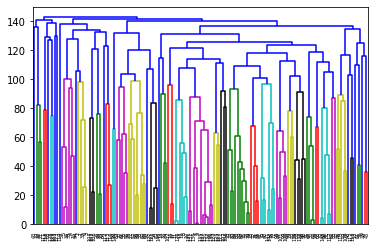

<IPython.core.display.Javascript object>

In [28]:
# answer goes here

plot_dendrogram(clst)



Finally, plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo

Tip: If the markers on the map are too large, their size can be changed with the following line of code:

*fig.update_traces(marker=dict(size=...)))*

Do the clusters correspond to geographic areas you would expect? Experiment with other values for n_cluster and linkage and see how they affect the results.

In [36]:
sbux["string_label"] = "cluster " + sbux["label"].astype(str)

<IPython.core.display.Javascript object>

In [37]:
# answer goes here

px.scatter_geo(data_frame=sbux, lat='Latitude', lon='Longitude', color='string_label', scope='usa')



<IPython.core.display.Javascript object>